In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Reading the datasets
data = pd.read_csv('protein.csv')
data_seq = pd.read_csv('protein_seq.csv')
data_seq.head()

,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


In [3]:
#Retrieving only protein records
data = data[data.macromoleculeType == 'Protein']
data_seq = data_seq[data_seq.macromoleculeType == 'Protein']

In [4]:
data = data[['structureId','classification']]
data_seq = data_seq[['structureId','sequence']]
data_seq.head()

,structureId,sequence
4,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [5]:
# merging 2 datasets into single dataset
new_data = data.merge((data_seq), how = 'inner', on = 'structureId')
new_data.head()

,structureId,classification,sequence
0,101M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
1,102L,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
2,102M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
3,103L,HYDROLASE(O-GLYCOSYL),MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
4,103M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [6]:
new_data.isnull().sum()

structureId       0
classification    1
sequence          3
dtype: int64

In [7]:
new_data.dropna(inplace = True)

In [8]:
#Retriving class labels whose count is more than 1000
counts = new_data.classification.value_counts()
types = np.asarray(counts[(counts > 5000)].index)
new_data = new_data[new_data.classification.isin(types)]


In [9]:
print(new_data.classification.value_counts())

HYDROLASE                        46336
TRANSFERASE                      36424
OXIDOREDUCTASE                   34321
IMMUNE SYSTEM                    15615
LYASE                            11682
HYDROLASE/HYDROLASE INHIBITOR    11218
TRANSCRIPTION                     8919
VIRAL PROTEIN                     8495
TRANSPORT PROTEIN                 8371
VIRUS                             6972
SIGNALING PROTEIN                 6469
ISOMERASE                         6356
Name: classification, dtype: int64


at least 6972 instances per class
188353 instances before
188353 instances after


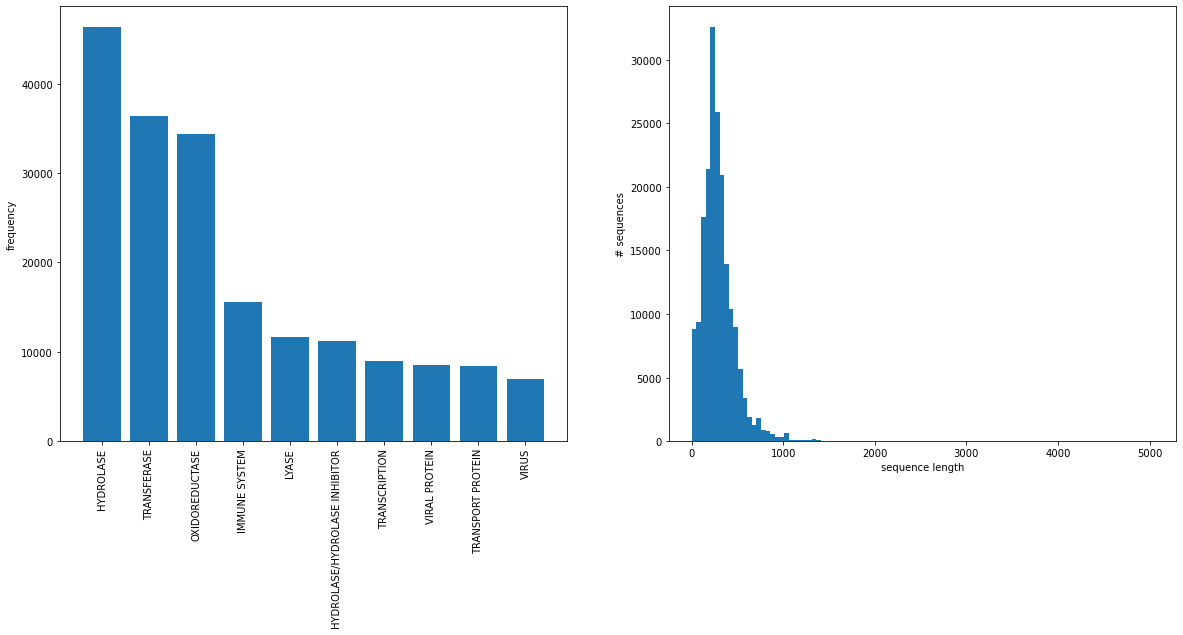

In [11]:
#Visualization
import matplotlib.pyplot as plt
from collections import Counter

# count numbers of instances per class
cnt = Counter(new_data.classification)
# select only 10 most common classes!
top_classes = 10
# sort classes
sorted_classes = cnt.most_common()[:top_classes]
classes = [c[0] for c in sorted_classes]
counts = [c[1] for c in sorted_classes]
print("at least " + str(counts[-1]) + " instances per class")

# apply to dataframe
print(str(new_data.shape[0]) + " instances before")
new_data = new_data[[c in classes for c in new_data.classification]]
print(str(new_data.shape[0]) + " instances after")

seqs = new_data.sequence.values
lengths = [len(s) for s in seqs]

# visualize
fig, axarr = plt.subplots(1,2, figsize=(20,8))
axarr[0].bar(range(len(classes)), counts)
plt.sca(axarr[0])
plt.xticks(range(len(classes)), classes, rotation='vertical')
axarr[0].set_ylabel('frequency')

axarr[1].hist(lengths, bins=100)
axarr[1].set_xlabel('sequence length')
axarr[1].set_ylabel('# sequences')
plt.show()

In [12]:
# spilting of data into train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(new_data['sequence'][0:20000], new_data['classification'][0:20000], test_size = 0.3, random_state = 42)
print(X_test.shape)
print(y_test.shape)
print(X_train.shape)
print(y_train.shape)

(6000,)
(6000,)
(14000,)
(14000,)


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a Count Vectorizer to gather the unique elements in sequence
vect = CountVectorizer(analyzer = 'char_wb', ngram_range = (6,6))

# Fit and Transform CountVectorizer
vect.fit(X_train)
X_train = vect.transform(X_train)
X_test = vect.transform(X_test)

#Print a few of the features
print(vect.get_feature_names()[-20:])

['zgaris', 'ziarbf', 'zigieh', 'ziwzkn', 'zkalpg', 'zkkytp', 'zkntav', 'zkyhng', 'zlikpg', 'zlzkal', 'zpvmwz', 'zrgdil', 'zrviks', 'ztvlep', 'ztzkyh', 'zvbdas', 'zvibzv', 'zvkavt', 'zwdllr', 'zzvbda']


In [14]:
#model creation and prediction
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [15]:
#checking for accuracy
from sklearn.metrics import accuracy_score
multinomialNB_acc = accuracy_score(y_test,y_pred)
print(multinomialNB_acc)

0.8963333333333333


In [16]:
from sklearn.ensemble import RandomForestClassifier 
classifier =  RandomForestClassifier(n_estimators = 20, max_depth = 10)
classifier.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, n_estimators=20)

In [17]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score
RF_acc = accuracy_score(y_test,y_pred)
print(RF_acc)

0.3431666666666667


In [18]:
from sklearn.tree import DecisionTreeClassifier 
classifier = DecisionTreeClassifier()
classifier.fit(X_train,y_train)

DecisionTreeClassifier()

In [19]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score
DT_acc = accuracy_score(y_test,y_pred)
print(DT_acc)

0.9271666666666667


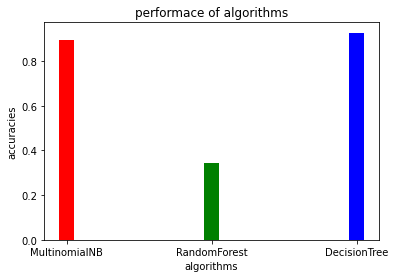

In [20]:
bar_graph = [multinomialNB_acc, RF_acc, DT_acc]
names=['MultinomialNB','RandomForest','DecisionTree']
tick_label = ['MultinomialNB','RandomForest','DecisionTree'] 
  
plt.bar(names,bar_graph, tick_label = tick_label, 
        width = 0.1, color = ['red', 'green','blue']) 
   
plt.xlabel('algorithms') 
plt.ylabel('accuracies') 
plt.title('performace of algorithms') 
plt.show() 


In [21]:
User_input  = input("Enter the protein sequence for which you want to predict the class Here:")

Enter the protein sequence for which you want to predict the class Here:ctct


In [22]:
y_pred=classifier.predict(X_test)

In [23]:
y_pred

array(['OXIDOREDUCTASE', 'OXIDOREDUCTASE', 'HYDROLASE', ...,
       'OXIDOREDUCTASE', 'LYASE', 'OXIDOREDUCTASE'], dtype=object)

In [26]:
x=[125]

In [27]:
prediction=classifier.predict(vect.transform(x))

AttributeError: 'int' object has no attribute 'lower'

In [ ]:
prediction